<a href="https://colab.research.google.com/github/tejas-shanthraj/srh-da3-deep-learning/blob/main/06_CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task: CIFAR-10 classification

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

> "consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

>The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

<img src="http://drive.google.com/uc?export=view&id=1wlfkvZgS0oBDwxKicWmYgtsJmP3IcMdj">

# Preliminaries

In [1]:
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam, SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.initializers import glorot_normal

# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(14)
tf.random.set_seed(19)

Download the data if necessary and load it:

In [2]:
from sklearn.model_selection import train_test_split

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# TODO: Split the images into different sets and normalise them
train_images = train_images/255.0
test_images = test_images/255.0

train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(train_images.shape, valid_images.shape, test_images.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(40000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)
(40000, 1) (10000, 1) (10000, 1)


### Categories:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

In [3]:
# TODO: Fill in the classes
classes = [
    'airplane', # Class 0
    'automobile', # Class 1
    'bird', # Class 2
    'cat', # Class 3
    'deer', # Class 4
    'dog', # Class 5
    'frog', # Class 6
    'horse', # Class 7
    'ship', # Class 8
    'truck' # Class 9
    ]

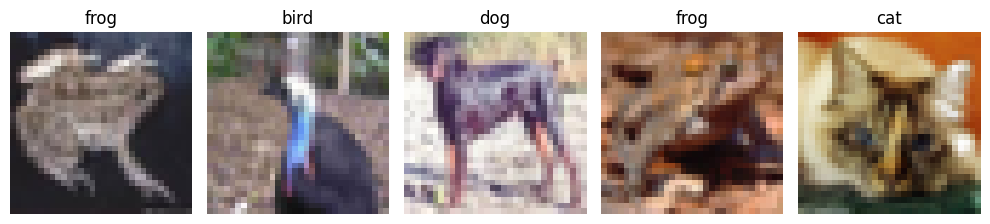

In [4]:
# TODO: Plot some of the images along with their labels
import matplotlib.pyplot as plt

# Number of images to plot
num_images_to_plot = 5

# Plot the first 'num_images_to_plot' images from the training set
plt.figure(figsize=(10, 5))

for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i + 1)

    # Plot the image
    plt.imshow(train_images[i])  # Using the 'train_images' from earlier

    # Get the class label for this image and map it to the class name
    label = train_labels[i][0]  # CIFAR-10 labels are stored as 2D arrays, we get the first element

    # Set the title of the plot to the class name
    plt.title(classes[label])
    plt.axis('off')  # Turn off axis for a cleaner view

# Display the plot
plt.tight_layout()
plt.show()


# Model

## Parameters

In [5]:
# TASK - Hyperparameters
# Fill in the initial values!
# Later, experiment!
#############################


# dropout - Something between 0.0 < dropout_rate < 1.0, think in "tens of percentages" as default
# dropout rate for conv layers
dropout_rate_1 = 0.4
# dropout rate for fully connected layers
dropout_rate_2 = 0.35

# Choose an appropriate batch size for the training!
batch_size = 64

# Choose an appropriate number of epochs
epoch_count = 20

# These are the default parameters, you can experiment with learning rates, schedules, ...

## Network

In [6]:
# adapted from https://github.com/jtopor/CUNY-MSDA-661/blob/master/CIFAR-CNN/TF-Layers-CIFAR-GITHUB-v3.py


tf.compat.v1.reset_default_graph() # It's good practice to clean and reset everything
clear_session()          # even using Keras


# WE USE FUNCTIONAL API!
# (Could be different, but not now...)



# Model
#######

# Define the input!
# Remember, we have pictures with 32x32 pixels and 3 color channels
# Disregard batch size, Keras will do that for us.
x = Input(shape=(32, 32, 3))

# Convolutional Layer #1: (batch_size, 32, 32, 3) -> (batch_size, 32, 32, 64)
# Define a "normal" convolutional layer for images (not a single sequence, so ?D)
# There should be 64 convolutional units
# The kernel should be 5 in width and heigth
# There should be padding so that the input and output dimensions would be equivalent
# The non-linearity should be ReLU
conv1 = Conv2D(64, (5, 5), padding='same', activation='relu')(x)

# Pooling Layer #1: (batch_size, 32, 32, 64) -> (batch_size, 16, 16, 64)
# Define a maximum based pooling layer with appropriate dimensions
# The pooling size should be 2,2 and stride 2
pool1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv1)

# Define a dropout layer with using the first dropout rate parameter
dropout1 = Dropout(dropout_rate_1)(pool1)

# Convolutional Layer #2: (batch_size, 16, 16, 64) -> (batch_size, 16, 16, 64)
# Repeat the prior conv layer
# Watch for the right input
conv2 = Conv2D(64, (5, 5), padding='same', activation='relu')(dropout1)

# Pooling Layer #2: (batch_size, 16, 16, 64) -> (batch_size, 8, 8, 64)
# Repeat the prior pooling layer
# Watch for the right input
pool2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv2)

# Define a dropout layer with using the FIRST dropout rate parameter
dropout2 = Dropout(dropout_rate_1)(pool2)

# Convert tensors into vectors: (batch_size, 8, 8, 64) -> (batch_size, 4096)
# Use a single KERAS function, NO numpy or reshape magic!
# Hint: the result is not 2D but "flat"
pool2_flat = Flatten()(dropout2)

# Fully connected Layer #1: (batch_size, 4096)-> (batch_size, 512)
# Define a fully connected layer with 512 nodes and ReLU
dense1 = Dense(512, activation='relu')(pool2_flat)

# Define a dropout layer with using the SECOND dropout rate parameter
dropout3 = Dropout(dropout_rate_2)(dense1)

# Dense Layer #1: (batch_size, 512)-> (batch_size, 256)
# Define a fully connected layer with 256 nodes and ReLU
dense2 = Dense(256, activation='relu')(dropout3)

# Define a dropout layer with using the SECOND dropout rate parameter
dropout4 = Dropout(dropout_rate_2)(dense2)

# Logits layer: (batch_size, 256) -> (batch_size, 10)
# Define a fully connected layer with ??? nodes
# Think about it, what shape should the output be?
# What activation?
# Think about it: we are in a classification problem!
predictions = Dense(10, activation='softmax')(dropout4)

# Full model
# Instantiate (initialize) the model with inputs and outputs
model = Model(inputs=x, outputs=predictions)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,338,890 (8.92 MB)

 Trainable params: 2,338,890 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

## Loss, optimization and compilation

In [7]:
# Loss
loss = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not
                                       # one-hot encoded

# Optimizer
# Choose an optimizer - adaptive ones work well here
optimizer = Adam(learning_rate=0.001)

# Compilation
#############
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Training

In [8]:
history = model.fit(x=train_images, y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=epoch_count,
                    batch_size=batch_size)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.2815 - loss: 1.9257 - val_accuracy: 0.4776 - val_loss: 1.4609
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4791 - loss: 1.4505 - val_accuracy: 0.5735 - val_loss: 1.2177
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5384 - loss: 1.2905 - val_accuracy: 0.6025 - val_loss: 1.1150
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5791 - loss: 1.1886 - val_accuracy: 0.6408 - val_loss: 1.0246
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6004 - loss: 1.1208 - val_accuracy: 0.6587 - val_loss: 0.9706
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6274 - loss: 1.0543 - val_accuracy: 0.6682 - val_loss: 0.9541
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6419 - loss: 1.0093 - val_accuracy: 0.6575 - val_loss: 0.9630
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6618 - loss: 0.9551 - val_accuracy: 0

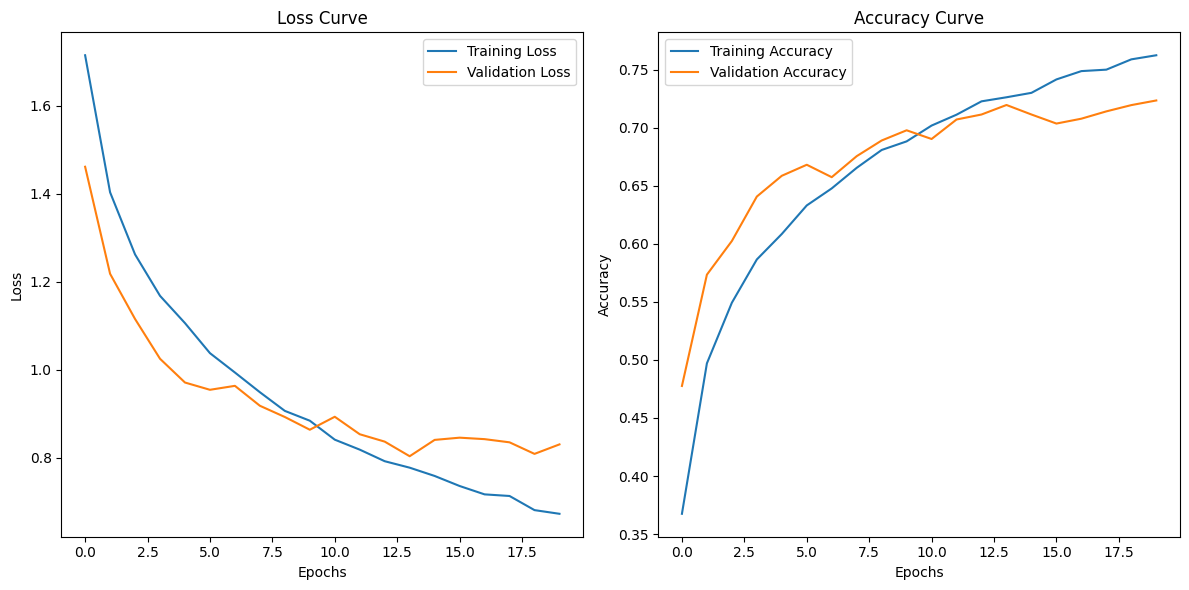

In [9]:
# TODO: Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [21]:
assert max(history.history['val_accuracy']) > 0.72

## Visualization

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


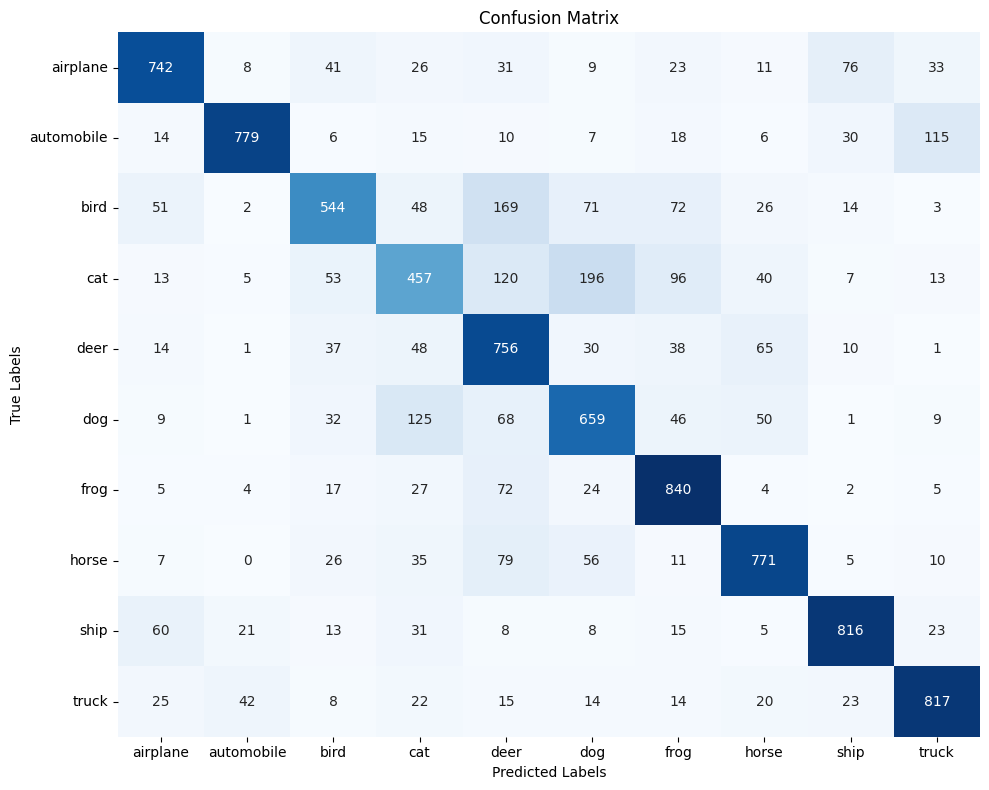

In [11]:
# TODO: Plot Confusion Matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Make predictions on the test set
test_predictions = model.predict(test_images)
predicted_labels = np.argmax(test_predictions, axis=1)  # Get the predicted class labels
true_labels = test_labels  # True labels for test set

# 2. Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# 3. Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 8))

# Heatmap with annotations
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=False)

# Title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


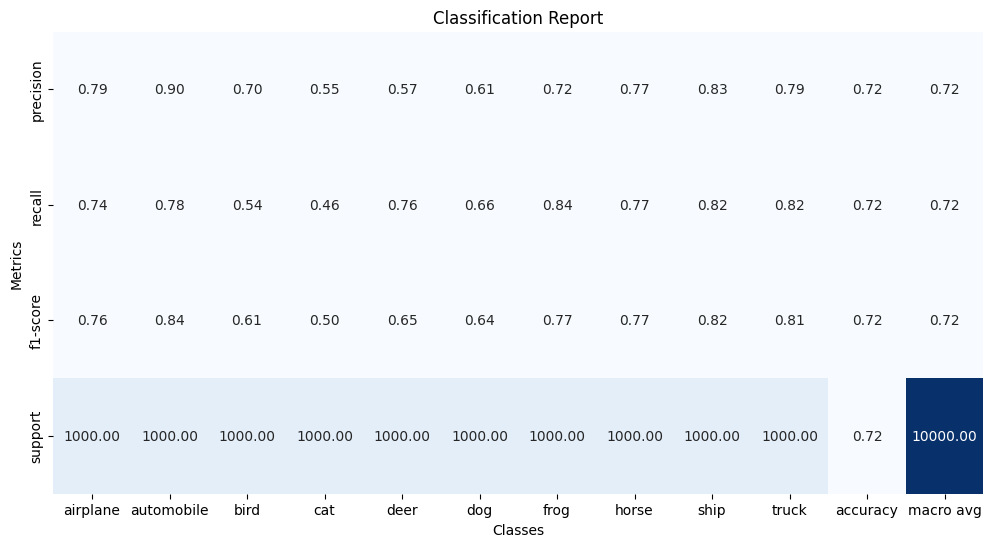

In [13]:
# TODO: Plot Classification Report
from sklearn.metrics import classification_report
import pandas as pd
# 1. Generate predictions on the test set
test_predictions = model.predict(test_images)
predicted_labels = np.argmax(test_predictions, axis=1)  # Get the predicted class labels

# 2. Get the classification report
report = classification_report(test_labels, predicted_labels, target_names=classes, output_dict=True)

# 3. Convert the report to a pandas DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# 4. Plot the classification report
plt.figure(figsize=(12, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.title('Classification Report')
plt.ylabel('Metrics')
plt.xlabel('Classes')
plt.show()